# 中心極限定理に関するシミュレーションの例

* 黒木玄
* 2025-12-14

Juliaの確率分布のパッケージDistributions.jlでは、確率分布のオブジェクトを `dist = Gamma(2, 3)` のような形式で構成でき、それを関数の引数として使える。そのお陰で、確率分布と標本サイズを任意に与えると、標本平均と不偏分散を大量に生成するシミュレーションを行って、結果をグラフで示す関数を作れる。

Google Colabでも実行できます。

* https://colab.research.google.com/github/genkuroki/public/blob/main/0055/plot_means_and_vars.ipynb

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

haskey(ENV, "COLAB_GPU") && (ENV["JULIA_PKG_PRECOMPILE_AUTO"] = "0")
using Pkg

"""すでにPkg.add済みのパッケージのリスト"""
_packages_added = [sort!(readdir(Sys.STDLIB));
    sort!([info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep])]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if isnothing(Base.find_package(pkg))
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd

In [2]:
using Random: rand!
using Printf
_nthreads() = Threads.nthreads(:interactive) + Threads.nthreads(:default)

@autoadd begin
using Distributions
using Plots
end

default(fmt=:png, legend=false)

function logtick(xmin, xmax; ts=(1, 2, 5))
    @assert xmin > 0
    xs = Float64[]
    xs_str = String[]
    for k in floor(Int, log10(xmin))-1:-1
        for t in ts
            x = 10.0^k * t
            if x > 0.5xmin
                push!(xs, x)
                x_str = "0." * "0"^(-k-1) * string(t)
                push!(xs_str, x_str)
            end
        end
    end
    for k in 0:ceil(Int, log10(xmax))
        for x in 10^k .* ts
            if x < xmax
                push!(xs, x)
                push!(xs_str, string(x))
            end
        end
    end
    (log.(xs), xs_str)
end

logtick (generic function with 1 method)

In [3]:
function plot_sample_means_and_unbiased_variaces(dist, n;
        niters=10^4, c=:auto, msc=:auto, ms=1.5, ma=0.3, kwargs...)
    X̄ = zeros(niters)
    S² = zeros(niters)
    nth = _nthreads()
    Xtmp = [zeros(eltype(dist), n) for _ in 1:nth]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        X = rand!(dist, Xtmp[tid])
        X̄[i] = mean(X)
        S²[i] = var(X)
    end
    scatter(X̄, log.(S²); c, msc, ms, ma, kwargs...)
    ytick = logtick(quantile(S², 0.001), maximum(S²))
    plot!(; ytick)
    plot!(; xguide="sample mean", yguide="unbiased variance (log scale)")
end

plot_sample_means_and_unbiased_variaces (generic function with 1 method)

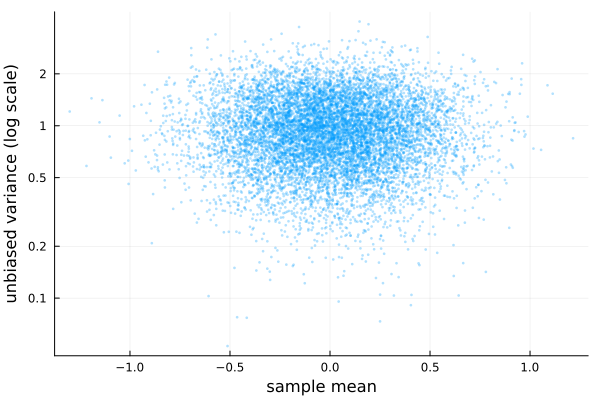

In [4]:
plot_sample_means_and_unbiased_variaces(Normal(), 10)

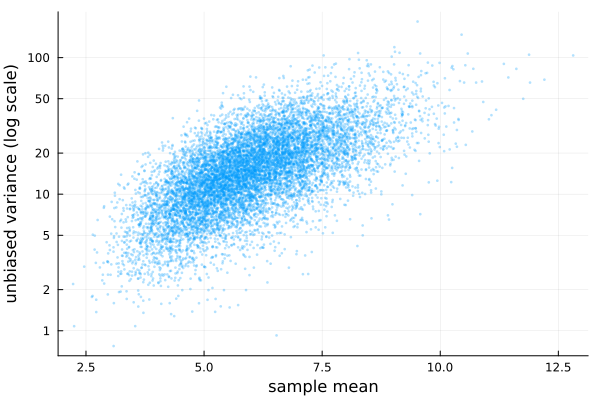

In [5]:
plot_sample_means_and_unbiased_variaces(Gamma(2, 3), 10)

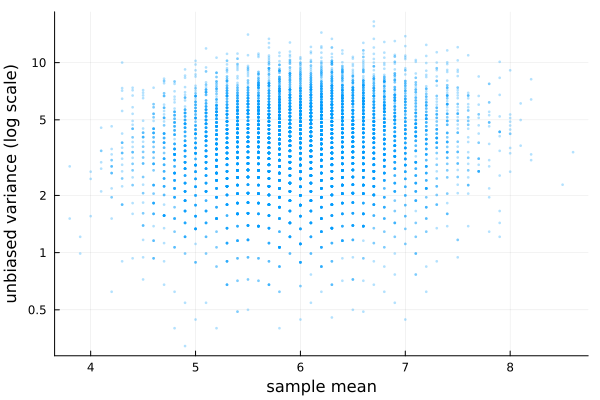

In [6]:
plot_sample_means_and_unbiased_variaces(Binomial(20, 0.3), 10)

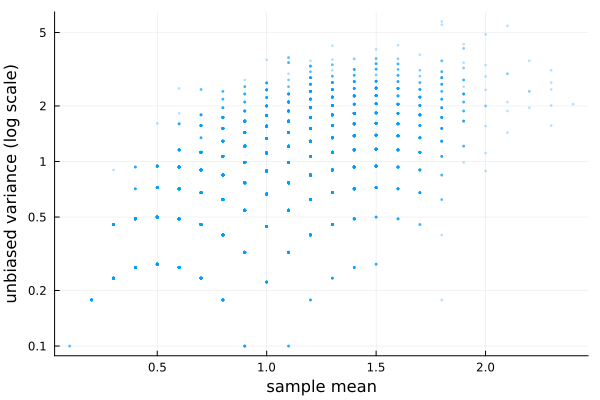

In [7]:
plot_sample_means_and_unbiased_variaces(Poisson(1), 10)